In [ ]:
%pip install python-binance

In [ ]:
%pip install matplotlib

In [ ]:
%pip install pandas

In [ ]:
import requests
import pandas as pd
from datetime import datetime
from pathlib import Path

# Base URL for Binance API
base_url = 'https://binance.com'

# Symbol to fetch
symbol = 'BTCUSDT'

# Function to convert datetime to timestamp in milliseconds
def timestamp_to_int(dt):
    return int(datetime.timestamp(dt) * 1000)

# Start and end time for data fetching
start_time = timestamp_to_int(datetime(2020, 1, 1))
end_time = timestamp_to_int(datetime(2023, 11, 29))

# Function to get funding rate and append to DataFrame
def get_funding_rate(df, start_time):
    endpoint = '/fapi/v1/fundingRate'
    params = {
        'symbol': symbol,
        'startTime': start_time,
        'endTime': end_time,
        'limit': 100  # Adjust as per API limits
    }
    url = base_url + endpoint
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        for funding_rate in data:
            rate = funding_rate['fundingRate']
            time = datetime.fromtimestamp(funding_rate['fundingTime'] / 1000).strftime('%Y-%m-%d %H:%M:%S')
            row = pd.Series({'symbol': symbol, 'rate': rate, 'time': time})
            df = pd.concat([df, row.to_frame().T], ignore_index=True)
            print(f'Symbol: {symbol}, Rate: {rate}, Time: {time}')
        # Update start_time to the last fetched time plus one millisecond
        if data:
            last_time = data[-1]['fundingTime'] + 1
        else:
            last_time = start_time
    else:
        print(f'Error: {response.status_code}')
        last_time = start_time
    return df, last_time

# Initialize DataFrame
df = pd.DataFrame()

# Fetch data in loop
while start_time < end_time:
    df, start_time = get_funding_rate(df, start_time)

# Print or process the DataFrame as needed
print(df)

# Save to CSV
filepath = Path('C:/Quant/BTCfunding_rate.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

In [10]:
import pandas as pd

# 指定你的 CSV 檔案路徑
csv_file_path = 'BTCfunding_rate.csv'

# 讀取 CSV 檔案
df = pd.read_csv(csv_file_path)

# 顯示 DataFrame 的前幾行
print(df.head())

   Unnamed: 0   symbol      rate            time
0           0  BTCUSDT -0.000024  2020/1/1 00:00
1           1  BTCUSDT -0.000124  2020/1/1 08:00
2           2  BTCUSDT -0.000124  2020/1/1 16:00
3           3  BTCUSDT -0.000097  2020/1/2 00:00
4           4  BTCUSDT  0.000037  2020/1/2 08:00


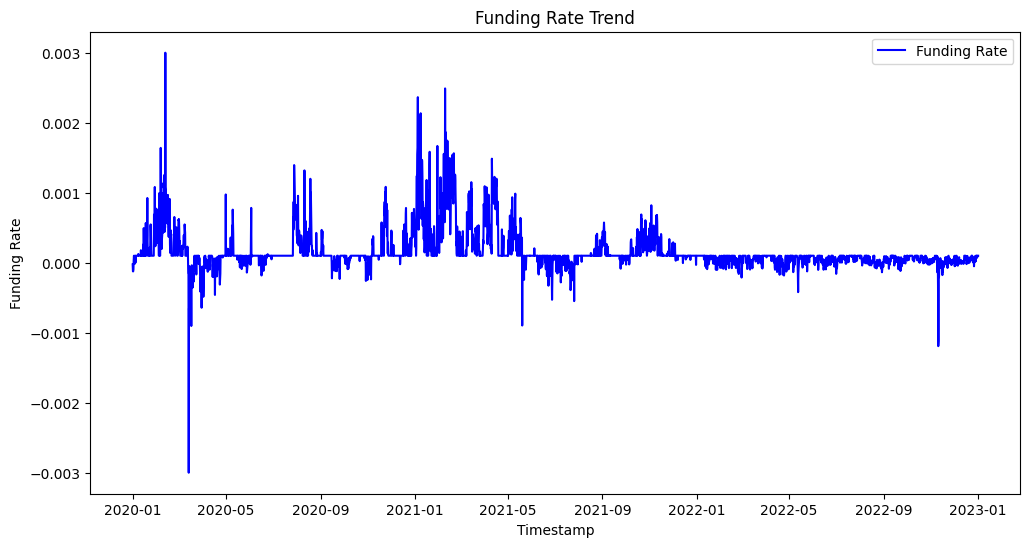

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設你上傳的檔案名稱為 "funding_rate.csv"
file_name = "BTCfunding_rate.csv"

# 讀取 CSV 檔案
df = pd.read_csv(file_name)

# 將 'time' 轉換為 datetime 格式
df['time'] = pd.to_datetime(df['time'])

# 繪製走勢圖
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['rate'], label='Funding Rate', color='blue')

plt.title('Funding Rate Trend')
plt.xlabel('Timestamp')
plt.ylabel('Funding Rate')
plt.legend()
plt.show()

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Binance API基礎URL和交易對
base_url = 'https://binance.com'
symbol = "BTCUSDT"

# 假設手續費 我還沒有仔細算
spot_rate = 0.001
future_rate = 0.0005
slippage_rate = 0.001  # 滑點率

def get_historical_klines(interval, start_time, end_time):
    endpoint = '/api/v3/klines'
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': int(start_time.timestamp() * 1000),
        'endTime': int(end_time.timestamp() * 1000),
        'limit': 1000
    }
    url = base_url + endpoint
    response = requests.get(url, params=params)
    data = response.json()

    # DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# fundingrate
def get_funding_rate(start_time, end_time):
    file_name = "BTCfunding_rate.csv"

    # 讀取 CSV 檔案
    df = pd.read_csv(file_name)
    df['time'] = pd.to_datetime(df['time'])

    # 篩選出在指定時間區間的資料
    filtered_df = df[(df['time'] >= start_time) & (df['time'] < end_time)]

    return filtered_df

#策略
def backtest(start_time, end_time):
    klines_df = get_historical_klines('8h', start_time, end_time)
    funding_rate_df = get_funding_rate(start_time, end_time)

    # 初始化資金
    capital = 10000
    spot_position = 0
    futures_short_position = 0
    in_short_trade = False
    in_long_trade = False
    trade_start_time = None
    last_exit_capital = 0  # 新增的變數
    slippage_cost = 0

    def calculate_slippage(current_price, slippage_rate):
      return current_price * slippage_rate
    
    for index, row in funding_rate_df.iterrows():
        current_time = row['time']
        funding_rate = row['rate']

        # 更新倉位價值
        if spot_position != 0 or futures_short_position != 0:
          eight_hours_ago = current_time - timedelta(hours=8)

          current_kline = klines_df[klines_df['timestamp'] == current_time]
          if eight_hours_ago in klines_df['timestamp'].values:
            eight_hours_ago_kline = klines_df[klines_df['timestamp'] == eight_hours_ago]

            if not current_kline.empty and not eight_hours_ago_kline.empty:
              current_price = float(current_kline['close'].values[0])
              eight_hours_ago_price = float(eight_hours_ago_kline['close'].values[0])
            else:
              # 如果數據不存在，假設八小時前的價格為現在的價格
              current_price = current_price
              eight_hours_ago_price = current_price
              print("Assuming eight hours ago price is the same as the current price.")

          spot_position = float(spot_position) * (current_price / eight_hours_ago_price)
          futures_short_position = float(futures_short_position) * (current_price / eight_hours_ago_price)
          slippage_cost = current_price * slippage_rate

        if funding_rate > 0 and spot_position == 0:
            # 資金費率為正，買入現貨，做空合約
            in_short_trade = True
            trade_start_time = current_time

            # 考慮手續費
            spot_after_fee = capital/2 * (1 - spot_rate)
            future_after_fee = capital/2 * (1 - future_rate)

            # 更新持倉
            spot_position = spot_after_fee - slippage_cost
            futures_short_position = future_after_fee - slippage_cost
            capital=0

            capital = futures_short_position * (1 + funding_rate) + spot_position

            print(f"Buy Spot and Short Futures at {current_time} - Spot Position: {spot_position}, Futures Short Position: {futures_short_position}, Capital: {capital}")
        '''
        elif funding_rate < 0 and spot_position == 0:
            # 資金費率為負，賣出現貨，做多合約
            in_long_trade = True
            trade_start_time = current_time

            # 考慮手續費
            spot_after_fee = capital/2 * (1 - spot_rate)
            future_after_fee = capital/2 * (1 - future_rate)

            # 更新持倉
            spot_position = spot_after_fee
            futures_long_position = future_after_fee
            capital=0

            capital = futures_long_position * (1 - funding_rate) + spot_position

            print(f"Sell Spot and Long Futures at {current_time} - Spot Position: {spot_position}, Futures Long Position: {futures_long_position}, Capital: {capital}")
        '''
        if funding_rate > 0 and in_short_trade != 0:

            capital += futures_short_position * (funding_rate)

            print(f"Buy Spot and Short Futures at {current_time} - Spot Position: {spot_position}, Futures Short Position: {futures_short_position}, Capital: {capital}")
        '''
        elif funding_rate < 0 and in_long_trade != 0:

            capital += futures_long_position * (-funding_rate)

            print(f"Sell Spot and Long Futures at {current_time} - Spot Position: {spot_position}, Futures Long Position: {futures_long_position}, Capital: {capital}")
        '''
        # 出場策略
        if capital < last_exit_capital:
            # 如果現在的價格小於上一次出場的價格，不出場
            print(f"Not exiting at {current_time} - Current Price: {current_price}, Last Exit Price: {last_exit_capital}")
        else:
            # 出場條件
            if funding_rate <= 0 and in_short_trade:
                # 資金費率為負，停止交易
                in_short_trade = False
                spot_position = 0
                futures_short_position = 0

                capital += futures_short_position * (1 + funding_rate - future_rate) + spot_position * (1 - spot_rate) - slippage_cost
                last_exit_capital = capital  # 更新上一次出場價格
                print(f"Sell Spot and Cover Futures at {current_time} - Spot Position: {spot_position}, Futures Short Position: {futures_short_position}, Capital: {capital}")
        '''
        elif funding_rate >= 0 and in_long_trade:
            # 資金費率為負，停止交易
            in_long_trade = False

            spot_position = 0
            futures_long_position =  0

            capital += futures_long_position * (1 - funding_rate - future_rate) + spot_position * (1 - spot_rate)
            print(f"Buy Spot and Cover Futures at {current_time} - Spot Position: {spot_position}, Futures Long Position: {futures_long_position}, Capital: {capital}")
        '''

    # 計算回測報酬率
    returns = (capital - 10000) / 10000
    print(f"\nBacktest Result - Final Capital: {capital}, Returns: {returns * 100}%")

# 定義回測的起點和終點
start_time = datetime(2021, 1, 1)
end_time = datetime(2022, 1, 1)

# 執行回測
backtest(start_time, end_time)

Buy Spot and Short Futures at 2021-01-01 00:00:00 - Spot Position: 4995.0, Futures Short Position: 4997.5, Capital: 9994.3362814
Buy Spot and Short Futures at 2021-01-01 00:00:00 - Spot Position: 4995.0, Futures Short Position: 4997.5, Capital: 9996.172562799999
Buy Spot and Short Futures at 2021-01-01 08:00:00 - Spot Position: 5011.454940959679, Futures Short Position: 5013.963176665865, Capital: 9997.313389841585
Buy Spot and Short Futures at 2021-01-01 16:00:00 - Spot Position: 5036.010300476097, Futures Short Position: 5038.53082615201, Capital: 9998.640337319961
Buy Spot and Short Futures at 2021-01-02 00:00:00 - Spot Position: 5107.830692304599, Futures Short Position: 5110.38716412257, Capital: 10000.401223425102
Buy Spot and Short Futures at 2021-01-02 08:00:00 - Spot Position: 5441.134243385742, Futures Short Position: 5443.857533797847, Capital: 10000.945609178481
Buy Spot and Short Futures at 2021-01-02 16:00:00 - Spot Position: 5524.755011801878, Futures Short Position: 552